In [1]:
# MCMC Pipeline: Combining Goodman & Weare (2010), Foreman-Mackey et al. (2013), and Akeret et al. (2013)
# This notebook demonstrates how to build a robust, parallelizable MCMC sampler for Bayesian inference.
# It includes:
# - A manual stretch move sampler (Goodman & Weare)
# - A production-ready sampler using emcee (Foreman-Mackey)
# - A Ray-parallelized cloud-scale MCMC using logistic regression (Akeret)
# - Mock CosmoHammer-style architecture with placeholder cosmology model and likelihood

In [2]:
# -----------------------------
# PART 0: Mock CosmoHammer Architecture (Akeret-style abstraction)
# -----------------------------

In [3]:
class CosmologyModel:
    """Mock of a computationally expensive theory prediction step (e.g. CAMB)."""
    def __init__(self):
        pass

In [4]:
    def predict(self, params):
        return np.sum(params**2)

In [5]:
class LikelihoodEvaluator:
    """Mock of a log-likelihood wrapper, e.g. WMAP7 likelihood code."""
    def __init__(self):
        self.model = CosmologyModel()

In [6]:
    def log_likelihood(self, params):
        theory_output = self.model.predict(params)
        return -0.5 * (theory_output - 10)**2

In [7]:
    def log_posterior(self, params):
        logp = -0.5 * np.sum(params**2)
        return logp + self.log_likelihood(params)

In [8]:
likelihood_evaluator = LikelihoodEvaluator()

In [10]:
# -----------------------------
# PART 1: Goodman & Weare (2010) - From Scratch Implementation
# -----------------------------

import numpy as np
import matplotlib.pyplot as plt

def log_prob_banana(x):
    return -((x[0] - x[1])**2 / (2 * 0.01) + (x[0] + x[1])**2 / 2)

def stretch_move(xk, Xj, a=2.0):
    n_dim = len(xk)
    z = np.random.uniform(1.0 / a, a)
    y = Xj + z * (xk - Xj)
    log_accept_ratio = (n_dim - 1) * np.log(z) + log_prob_banana(y) - log_prob_banana(xk)
    return y if np.log(np.random.rand()) < log_accept_ratio else xk

def run_gw_sampler(n_walkers=20, n_dim=2, n_steps=1000, a=2.0):
    ensemble = np.random.randn(n_walkers, n_dim)
    samples = np.zeros((n_steps, n_walkers, n_dim))
    for t in range(n_steps):
        for k in range(n_walkers):
            j = np.random.choice([i for i in range(n_walkers) if i != k])
            ensemble[k] = stretch_move(ensemble[k], ensemble[j], a)
        samples[t] = ensemble
    return samples

In [11]:
!pip install emcee

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 5.0 MB/s eta 0:00:00


In [13]:
# -----------------------------
# PART 2: Foreman-Mackey et al. (2013) - Using the emcee Package
# -----------------------------

import emcee

def log_prob_emcee(x):
    return log_prob_banana(x)

def run_emcee_sampler(n_walkers=50, n_dim=2, n_steps=2500):
    p0 = np.random.randn(n_walkers, n_dim)
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_prob_emcee)
    state = sampler.run_mcmc(p0, n_steps, progress=False)
    return sampler

In [14]:
!pip install ray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 MB 12.5 MB/s eta 0:00:00


In [17]:
# -----------------------------
# PART 3: Akeret et al. (2013) - Ray-Parallel emcee Sampler + Real-world Likelihood
# -----------------------------

import ray
from sklearn.datasets import make_classification
from scipy.special import expit

ray.shutdown()
ray.init(ignore_reinit_error=True)

def create_dataset():
    X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, random_state=42)
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    return X, y

2025-05-07 22:32:04,772	INFO worker.py:1888 -- Started a local Ray instance.


In [18]:
X_data, y_data = create_dataset()

In [19]:
def log_likelihood_logistic(theta):
    beta, bias = theta[:2], theta[2]
    logits = X_data @ beta + bias
    return np.sum(y_data * logits - np.log1p(np.exp(logits)))

def log_prior(theta):
    return -0.5 * np.sum(theta**2)

def log_posterior(theta):
    return log_likelihood_logistic(theta) + log_prior(theta)

In [20]:
# Optionally switch to mock CosmoHammer model
USE_COSMO_MOCK = False

def log_post_selector(theta):
    if USE_COSMO_MOCK:
        return likelihood_evaluator.log_posterior(theta)
    else:
        return log_posterior(theta)

In [21]:
@ray.remote
def run_ray_emcee_chain(seed=0, n_walkers=50, n_steps=2500, burn_in=500):
    np.random.seed(seed)
    ndim = 3
    p0 = np.random.randn(n_walkers, ndim)
    sampler = emcee.EnsembleSampler(n_walkers, ndim, log_post_selector)
    state = sampler.run_mcmc(p0, burn_in, progress=False)
    sampler.reset()
    sampler.run_mcmc(state, n_steps, progress=False)
    return {
        "chain": sampler.get_chain(),
        "autocorr": sampler.get_autocorr_time(tol=0),
        "acceptance": np.mean(sampler.acceptance_fraction),
        "seed": seed
    }

In [22]:
import time

In [23]:
start_par = time.time()
results = ray.get([run_ray_emcee_chain.remote(seed=i) for i in range(4)])
end_par = time.time()
print(f"Parallel Ray runtime: {end_par - start_par:.2f} seconds")

all_samples = np.vstack([r["chain"].reshape(-1, 3) for r in results])
param_names = ["β₀", "β₁", "bias"]
end_par = time.time()

Parallel Ray runtime: 18.18 seconds


In [24]:
!pip install corner

β₀: mean=3.761, std=0.554, 95% CI=[2.744, 4.912]
β₁: mean=-0.858, std=0.381, 95% CI=[-1.636, -0.141]
bias: mean=-0.010, std=0.357, 95% CI=[-0.716, 0.690]


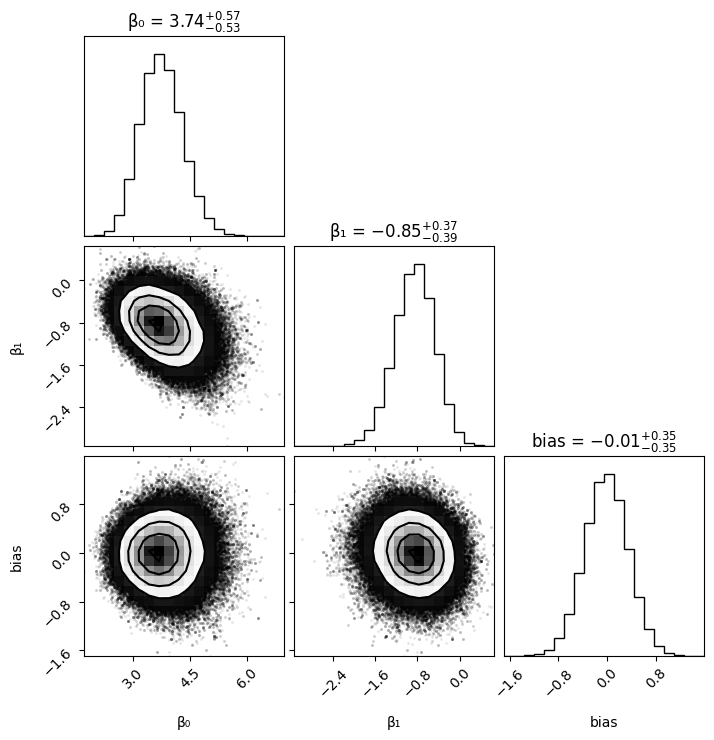

In [25]:
import corner
for i, name in enumerate(param_names):
    samples_i = all_samples[:, i]
    mean = np.mean(samples_i)
    std = np.std(samples_i)
    ci_lower, ci_upper = np.percentile(samples_i, [2.5, 97.5])
    print(f"{name}: mean={mean:.3f}, std={std:.3f}, 95% CI=[{ci_lower:.3f}, {ci_upper:.3f}]")

corner.corner(all_samples, labels=param_names, show_titles=True); plt.show()

In [26]:
from sklearn.metrics import accuracy_score

In [27]:
# Posterior Predictive
X_test, y_test = make_classification(n_samples=50, n_features=2, n_redundant=0, random_state=123)
X_test = (X_test - X_data.mean(axis=0)) / X_data.std(axis=0)
posterior_draws = all_samples[np.random.choice(len(all_samples), 100, replace=False)]

y_preds = []
for theta in posterior_draws:
    beta, bias = theta[:2], theta[2]
    logits = X_test @ beta + bias
    probs = expit(logits)
    y_preds.append(probs > 0.5)

y_pred_mode = np.mean(y_preds, axis=0) > 0.5
acc = accuracy_score(y_test, y_pred_mode)
print(f"Posterior Predictive Accuracy: {acc:.2f}")


Posterior Predictive Accuracy: 0.94
